<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">


## Naive Bayes Spam Filter Using SpamAssassin Data

<br>

---

In this lab we will write our own spam filter -- one of the many practical uses of Naive Bayes. We will additionally explore methods for visualizing text features in an effort to gain insight and improve our models.

### Background

The statistical approach for classifying spam was championed by Paul Graham, founder of Y Combinator. We highly recommend you read his classic (and very readable!) essay [A Plan for Spam](http://www.paulgraham.com/spam.html) to gain insight into why Naive Bayes works so well with spam.

The reason why Naive Bayes works incredibly well to classify spam is because spam aligns with the independence assumption. Certain keywords in emails -- taken by themselves (e.g. Nigeria / prince) -- typically indicate a spam message.

In this lab, the word **ham** indicates an email message that was authorized by the user. Sometimes we receive advertising emails that look like spam, yet we agreed to receive them. This fact can make spam detection more difficult. For a challenge, try classifying the `hard_ham` dataset below.

# Spam Lab
---

### 1. Download the data

We are using the data files from the SpamAssassin dataset:

+ https://spamassassin.apache.org/old/publiccorpus/20021010_easy_ham.tar.bz2
+ https://spamassassin.apache.org/old/publiccorpus/20021010_hard_ham.tar.bz2
+ https://spamassassin.apache.org/old/publiccorpus/20021010_spam.tar.bz2

From the command line, you can either use ```wget``` or ```curl``` to download into the current directory. For an example of each:

    wget http://spamassassin.apache.org/old/publiccorpus/20021010_easy_ham.tar.bz2
    curl http://spamassassin.apache.org/old/publiccorpus/20021010_easy_ham.tar.bz2 > 20021010_easy_ham.tar.bz2

You can use ```tar xvf <file>``` to extract into the current directory (x - extract, v - verbose, f - read from file). For example:

    tar xvf 20021010_easy_ham.tar.bz2

### Imports

In [1]:
import glob

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
%matplotlib inline

### 1. Get directory contents

In [2]:
# NOTE: Ensure base_dir points to the base directory where you extracted your data files!
#   Inside this directory should be three folders -- easy_ham, hard_ham, and spam.

base_dir = '../datasets'
easy_ham_files = glob.glob(base_dir + "/easy_ham/*")
hard_ham_files = glob.glob(base_dir + "/hard_ham/*")
spam_files = glob.glob(base_dir + "/spam/*")
spam_files

['../datasets/spam/0355.94ebf637e4bd3db8a81c8ce68ecf681d',
 '../datasets/spam/0395.bb934e8b4c39d5eab38f828a26f760b4',
 '../datasets/spam/0485.9021367278833179285091e5201f5854',
 '../datasets/spam/0343.0630afbe4ee1ffd0db0ffb81c6de98de',
 '../datasets/spam/0125.44381546181fc6c5d7ea59e917f232c5',
 '../datasets/spam/0108.4506c2ef846b80b9a7beb90315b22701',
 '../datasets/spam/0112.ec411d26d1f4decc16af7ef73e69a227',
 '../datasets/spam/0060.140f80780520fa19b360ddcb05838a67',
 '../datasets/spam/0392.9e194dfff92f7d9957171b04a8d4b957',
 '../datasets/spam/0441.b820c1999715c2e5ded6418d2b17723c',
 '../datasets/spam/0272.97ecf97bd5f1563ac88d9eb4c8a51062',
 '../datasets/spam/0278.229f1cdd03eb4e6ff86e9fd29551f577',
 '../datasets/spam/0126.713b324e028cc69213e67ad3d7319f5d',
 '../datasets/spam/0246.3b997087302d48ff57ab5afb3d400d5b',
 '../datasets/spam/0440.16a3caff5b5788f2ae378850041252d7',
 '../datasets/spam/0230.035bbcbe1235cb6fdd0a5d6d626dc5c4',
 '../datasets/spam/0068.1626952077798d4f2d5eb30e48bc49b3

In [3]:
# use io's open function, which supports the encoding parameter
from io import open

# Create list of full-text of all ham and spam emails

# read the easy ham files into a list
easy_ham_text = []
for filename in easy_ham_files:
    with open(filename, 'r', encoding='iso-8859-15') as f:
        easy_ham_text.append(f.read())

# read the easy ham files into a list
hard_ham_text = []
for filename in hard_ham_files:
    with open(filename, 'r', encoding='iso-8859-15') as f:
        hard_ham_text.append(f.read())

# read the spam files into a list
spam_text = []
for filename in spam_files:
    with open(filename, 'r', encoding='iso-8859-15') as f:
        spam_text.append(f.read())

print(easy_ham_text[0])

From rssfeeds@jmason.org  Mon Sep 30 13:43:46 2002
Return-Path: <rssfeeds@example.com>
Delivered-To: yyyy@localhost.example.com
Received: from localhost (jalapeno [127.0.0.1])
	by jmason.org (Postfix) with ESMTP id AE79816F16
	for <jm@localhost>; Mon, 30 Sep 2002 13:43:46 +0100 (IST)
Received: from jalapeno [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for jm@localhost (single-drop); Mon, 30 Sep 2002 13:43:46 +0100 (IST)
Received: from dogma.slashnull.org (localhost [127.0.0.1]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g8U81fg21359 for
    <jm@jmason.org>; Mon, 30 Sep 2002 09:01:41 +0100
Message-Id: <200209300801.g8U81fg21359@dogma.slashnull.org>
To: yyyy@example.com
From: gamasutra <rssfeeds@example.com>
Subject: Priceless Rubens works stolen in raid on mansion
Date: Mon, 30 Sep 2002 08:01:41 -0000
Content-Type: text/plain; encoding=utf-8
Lines: 6
X-Spam-Status: No, hits=-527.4 required=5.0
	tests=AWL,DATE_IN_PAST_03_06,T_URI_COUNT_0_1
	version=2.50-cvs
X-Spam

In [4]:
# Let's merge all of the emails into a single list of emails -- this is our data!
ham_and_spam_text = easy_ham_text + spam_text    # extends the lists

In [5]:
# How imbalanced is our dataset?

print(len(spam_text))
print(len(easy_ham_text))
print(len(ham_and_spam_text))

467
2374
2841


In [6]:
# ham_and_spam_text[0]

### 2. Label the data

We now have `ham_and_spam_text`, a single list containing our emails. However, now we need this data to be labeled with what we will predict. In this case, we will make a list of 0s and 1s indicating whether each of these emails is ham (0) or spam (1). Can you make this list, given how we combined the spam and ham into one list above?

In [11]:
y = np.array([0] * len(easy_ham_text) + [1] * len(spam_text))
y

array([0, 0, 0, ..., 1, 1, 1])

### 3. Transform the emails into features
 
We will be using cross validation later to assess performance, so feel free to fit it on the entire dataset for now.

#### 3.A. Fit the model on your data using `CountVectorizer`

Using `CountVectorizer` ONLY, transform each email into features. Consider now or later removing stopwords, trying different ngram sizes, making all words lowercase, and/or creating your own features (e.g. presence of an unsubscribe link!). 

In [8]:
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()
analyzer = CountVectorizer().build_analyzer()


def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

In [16]:
vect = CountVectorizer(stop_words='english',
                       decode_error='ignore',
                       analyzer=stemmed_words)
vect.fit(ham_and_spam_text)

CountVectorizer(analyzer=<function stemmed_words at 0x11ae2f400>,
        binary=False, decode_error='ignore', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=None,
        stop_words='english', strip_accents=None,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, vocabulary=None)

#### 3.B. Transform the data

In [42]:
words = vect.get_feature_names()
words[6738]

'2002'

In [20]:
# It might take a while
train_X = vect.transform(ham_and_spam_text)
train_X

<2841x69130 sparse matrix of type '<class 'numpy.int64'>'
	with 700108 stored elements in Compressed Sparse Row format>

#### 3.C. Create a dense matrix for scikit-learn

Create a dense 2-D ndarray `X` from the sparse matrix. Make a 1-D ndarray `y` (the list of labels you created earlier).

In [21]:
X = train_X.toarray()  # Converts sparse matrix -> dense
print(X.shape)

y = np.array([0] * len(easy_ham_text) + [1] * len(spam_text))
y.shape

(2841, 69130)


(2841,)

### 4. Understand and visualize your features

Sometimes you may find it difficult to visualize text data. This section provides some exercises that give you insight into how you may modify your text features for improved performance.

#### 4.A. Understand sparse matrices and the transform

**For email index 1, print(a list of words and counts, sorted by descending count.** Use only the `train_X` sparse matrix along with the `get_feature_names()` method of your vectorizer. The index of each column in `train_X` refers to a word. That word is given by the element at that same index in `get_feature_names()`!

In [33]:
train_X[0].todense()

matrix([[1, 0, 1, ..., 0, 0, 0]])

In [34]:
# train_X[0].indices

In [35]:
bag = sorted(list(zip(train_X[0].indices, train_X[0].data)),
       key=lambda x: -x[1])

In [41]:
bag[:5]

[(6738, 6), (46169, 6), (51111, 6), (9487, 5), (26175, 5)]

In [40]:
train_X[0].indices   # indices of words in email 0
train_X[0].data      # counts of each word in email 0 
[(words[index], freq) for index, freq in bag][:5]

[('2002', 6), ('localhost', 6), ('org', 6), ('30', 5), ('com', 5)]

- Notice that the most common words in the email are garbage words from the email header! 
- You can likely improve your model by filtering these in some way.

#### 4.B. Using a histogram, visualize the number of emails each word is in.

What distribution is it? From this histogram, will most words in your model be noise or signal? Seeing this histogram, what can you likely do to improve your model? (Hint: To quickly graph this, use `np.sum` on the dense matrix `X` of word counts!)

In [43]:
import collections

c_ = collections.Counter(np.sum(X, axis=0))
c_.most_common(5)

[(1, 48608), (2, 11944), (3, 3391), (4, 2642), (5, 1281)]

Text(0.5,1,'Number of Emails containing each Word')

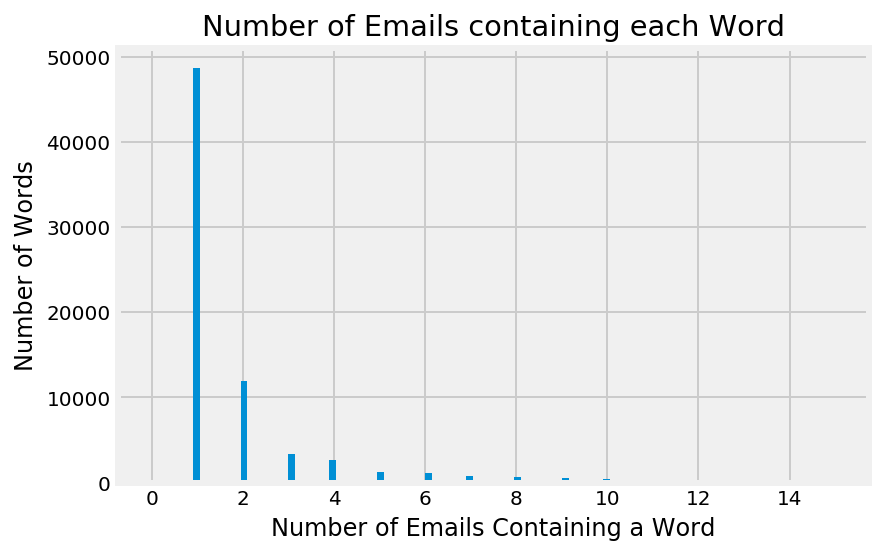

In [51]:
emails_per_word = np.sum(X, axis=0)

plt.hist(emails_per_word, bins=100, range=(0, 15))

plt.xlabel('Number of Emails Containing a Word')
plt.ylabel('Number of Words')
plt.title('Number of Emails containing each Word')

# 4.C. Using a histogram, visualize the number of words each email contains.

What is the distribution? Are there any outlier emails? Can you find an explanation why there is there likely a spike in the histogram (e.g. are the emails in this dataset of a particular type?) 

- Plot the distribution of number of words for spam emails on top of the distribution for ham emails! Would this be a useful additional feature?

Text(0.5,1,'Number of Words per Email')

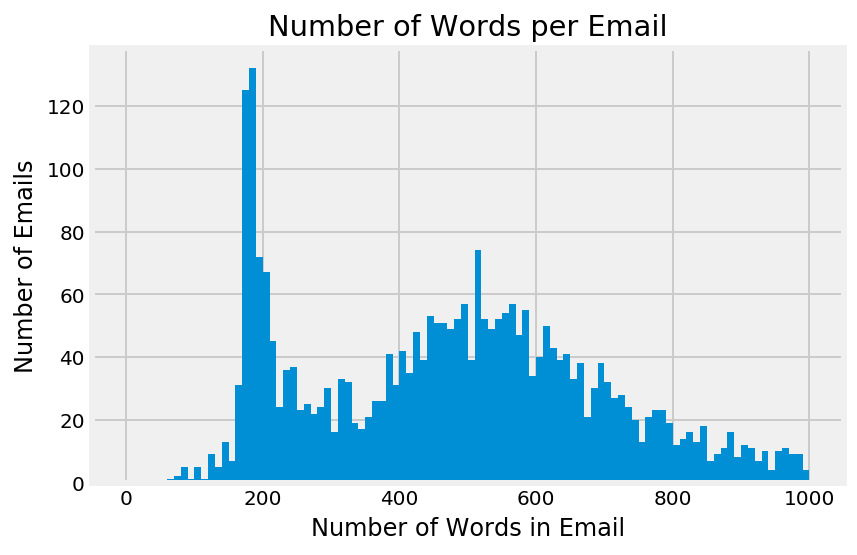

In [52]:
words_per_email = np.sum(X, axis=1)

plt.hist(words_per_email, bins=100, range=(0, 1000))
plt.xlabel('Number of Words in Email')
plt.ylabel('Number of Emails')
plt.title('Number of Words per Email')

Text(0.5,1,'Number of Words per Email')

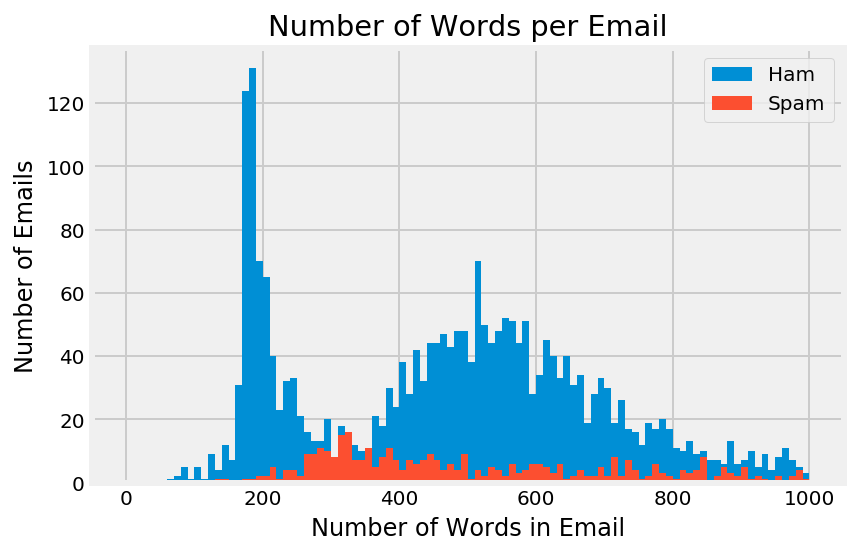

In [53]:
plt.hist(words_per_email[:len(easy_ham_text)], bins=100, range=(0, 1000));
plt.hist(words_per_email[len(easy_ham_text):], bins=100, range=(0, 1000));

plt.legend(['Ham', 'Spam'])
plt.xlabel('Number of Words in Email')
plt.ylabel('Number of Emails')
plt.title('Number of Words per Email')

### 5. Estimate generalization accuracy

Use `cross_val_score` with the models `BernoulliNB` and `MultinomialNB` to assess how well these models classify emails. Can you guess why one may perform better than the other?

In [54]:
# Bernoulli: Models whether a word in email or not
# Multinomial: Models the # of words per email

print('Bernoulli: ', cross_val_score(BernoulliNB(), X, y))
print('Multinomial: ', cross_val_score(MultinomialNB(), X, y))

Bernoulli:  [0.85363458 0.91543756 0.91248771]
Multinomial:  [0.90373281 0.95476893 0.97148476]


### 6. Confusion matrix and Classification report

Recall that to make a confusion matrix, we will need a specific split. So, use `test_train_split`, manually fit the model using the best performer, then find the confusion matrix and classification report (in the `metrics` package). Is your model worse at Type I or Type II errors?

In [55]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3)

In [56]:
print(X_train.shape, '/', y_train.shape)
print(X_test.shape, '/', y_test.shape)
916. / (916. + 2136.)

(2136, 78035) / (2136,)
(916, 78035) / (916,)


0.30013106159895153

In [57]:
model = MultinomialNB().fit(X_train, y_train)
preds = model.predict(X_test)

from sklearn import metrics
print('Accuracy:\n', metrics.accuracy_score(y_test, preds))
print('Confusion Matrix:\n', metrics.confusion_matrix(y_test, preds))
print('Classification Report:\n', metrics.classification_report(y_test, preds))

# 2 false positives (row 0, col 1) - Type I
# 20 false negatives (row 1, col 0) - Type II

Accuracy:
 0.9672489082969432
Confusion Matrix:
 [[755   2]
 [ 28 131]]
Classification Report:
              precision    recall  f1-score   support

          0       0.96      1.00      0.98       757
          1       0.98      0.82      0.90       159

avg / total       0.97      0.97      0.97       916



### 7. Test your model on the hard_ham

Does it perform as well?

In [58]:
# Answer: Not at all. It only got 33% accuracy!

X_test_hard = vect.transform(hard_ham_text)
y_test_hard = np.array([0] * len(hard_ham_text))

preds_hard = model.predict(X_test_hard.toarray())

print('Accuracy:\n', metrics.accuracy_score(y_test_hard, preds_hard))
print('Confusion Matrix:\n', metrics.confusion_matrix(y_test_hard, preds_hard))
print('Classification Report:\n', metrics.classification_report(y_test_hard, preds_hard))

# 168 false positives (row 0, col 1) - Type I

Accuracy:
 0.332
Confusion Matrix:
 [[ 83 167]
 [  0   0]]
Classification Report:
              precision    recall  f1-score   support

          0       1.00      0.33      0.50       250
          1       0.00      0.00      0.00         0

avg / total       1.00      0.33      0.50       250



/Users/aymericflaisler/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Text(0.5,1,'Number of Words per Email')

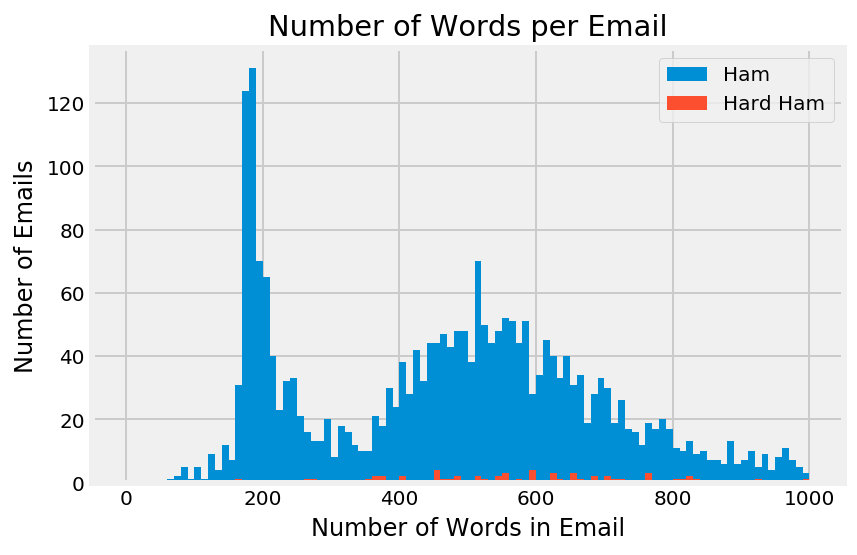

In [59]:
# Just for illustration, the hard ham is much more like spam by num of words. (these are not normalized)

words_per_email_hard = np.sum(X_test_hard, axis=1)

plt.hist(words_per_email[:len(easy_ham_text)], bins=100, range=(0, 1000));
plt.hist(words_per_email_hard, bins=100, range=(0, 1000))

plt.legend(['Ham', 'Hard Ham'])
plt.xlabel('Number of Words in Email')
plt.ylabel('Number of Emails')
plt.title('Number of Words per Email')

### 8. Improve your model by looking at mispredictions

Print the most common words in your false positives of the hard hams versus the spams. (Perhaps write a function of step 4A. Consider using a `collections.Counter` to combine the counts!) Does comparing the most frequent words in the hard ham to those in the spam give you some ideas for how to distinguish between them? What extra features might you add to your model?

In [67]:
from collections import Counter


def get_wordcounts(email):
    bag = sorted(list(zip(email.indices, email.data)),
                 key=lambda x: -x[1])

    bag_set = {words[index]: freq for index, freq in bag}

    return Counter(bag_set)


def total_word_counts(emails):
    word_counts = Counter()

    for email in emails:
        word_counts.update(get_wordcounts(email))

    return word_counts

In [68]:
# Spam:
spam_emails = vect.transform(spam_text)
spam_counts = get_wordcounts(spam_emails)

# Hard emails:
hard_falsepositive_idxs = np.argwhere(y_test_hard == preds_hard).flatten()
hard_counts = total_word_counts(X_test_hard[hard_falsepositive_idxs])
        

print (spam_counts.most_common(50))
print ('')
print (hard_counts.most_common(50))

[('enenkio', 129), ('25pt', 93), ('atol', 91), ('milf', 58), ('inset', 57), ('hermio', 54), ('ebonylust4fre', 49), ('kio', 45), ('easyadpost', 43), ('eneen', 41), ('friendfind', 40), ('prizeinthebag', 39), ('fromyou2', 38), ('wake', 38), ('e89', 38), ('nasti', 37), ('dqogicagica8yni', 37), ('nsi', 37), ('hanmail', 36), ('crackmic', 35), ('cc3333', 33), ('botan', 33), ('cpillc', 32), ('listmgmt', 31), ('marshalles', 31), ('œž²', 30), ('1167', 30), ('1596', 30), ('1d', 30), ('a248', 30), ('akamai', 30), ('columbiahous', 30), ('xyak', 30), ('2ffont', 29), ('3cfont', 29), ('linkgift', 29), ('_0', 29), ('aff', 29), ('shangrila', 29), ('5in', 28), ('marriott', 28), ('eluxmedia', 27), ('pour', 26), ('1736', 26), ('5138', 26), ('990', 26), ('adfarm', 26), ('mediaplex', 26), ('rv', 26), ('roster', 25)]

[('http', 4260), ('com', 3800), ('the', 3313), ('www', 2328), ('to', 2261), ('and', 1491), ('of', 1490), ('for', 1147), ('in', 1117), ('org', 953), ('from', 937), ('net', 937), ('2002', 913), ('

### Extensions

- Can you improve the score on the hard ham?
- Try to improve your model by changing or tweaking the model type. (e.g. LogisticRegression/RandomForests) Why do bigrams result in a lower accuracy? (Because nearly all of them are single-email, so they actually add MORE noise!)
- Remove features from your model, e.g. junk words.
- Add additional features to your model. Can you specifically come up with ideas that might detect spam vs. ham? For example, does an email have an unsubscribe link?